# Aggregate extraced time across multiple traces

1. Input parameters: directory with JSON traces, trace name pattern, (multiple) event patterns.  
   a. In trace name pattern, use one group for the varying parameter value (MBS).
2. For each event pattern, extract event time from all traces one by one using parseOneTrace script.
3. Aggregate values into one DF along with the varying parameter value extracted from the trace filename.


In [9]:
import os
import pandas as pd
import subprocess
import re
import string
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import cm
from sklearn import linear_model

## Set input parameters

In [10]:
logdir = 'logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont'
trace_name_pattern = 'nsys_trace_([0-9]+).json'
event_patterns = [
    'Iteration [123456789]+'
]


## Read trace files

In [11]:
list_command = "ls -1 " + logdir
files = []
param_values = []
proc = subprocess.Popen(list_command.split(" "),
                        stdout=subprocess.PIPE,
                        stderr=subprocess.STDOUT,
                        encoding='utf8')
for line in iter(proc.stdout.readline, ''):
    line = line.strip(" \n")
    m = re.match(trace_name_pattern, line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir, line)))
        param_values.append(m.group(1))

print('{} files in {}'.format(len(files), logdir))
print(tuple(zip(files,param_values)))

27 files in logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont
(('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_10.json', '10'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_100.json', '100'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_110.json', '110'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_12.json', '12'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_120.json', '120'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_130.json', '130'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_140.json', '140'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_15.json', '15'), ('/HDD2/ML/nsys

In [12]:
convert_traces = False

results = None
for param, tracefile in zip(param_values, files):
    events = '@'.join(event_patterns)
    print("Events: {}".format(events))
    if convert_traces:
        # Run
        # python3 parseOneTrace.py -f $tracefile --events $events
        command = 'python3@parseOneTrace.py@-f@{}@--events@{}'.format(
            tracefile, events)
        print(command.split('@'))
        p = subprocess.run(command.split('@'),
                           stdin=subprocess.PIPE,
                           stderr=subprocess.PIPE,
                           bufsize=0,
                           shell=False)
        if p.returncode == 0:
            print('Finished OK')
        else:
            if p.stdout is not None:
                print(p.stdout.decode('utf-8'))
            print('ERROR')
            print(p.stderr.decode('utf-8'))
    # Read data from CSV file
    directory = os.path.dirname(tracefile)
    csvfile = ('').join(os.path.basename(tracefile).split('.')
                        [:-1])  # Filename without extension
    csvfile = csvfile + '.csv'
    csvfile = os.path.join(directory, csvfile)
    print('Reading {}'.format(csvfile))
    df_ = pd.read_csv(csvfile)
    df_['param'] = param
    #     display(df_.head())
    if results is None:
        results = df_
    else:
        results = results.append(df_, ignore_index=True)

results.sample(n=8)

Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_10.csv
Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_100.csv
Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_110.csv
Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_12.csv
Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_120.csv
Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_130.csv
Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_140.csv
Events: Iterati

,name,start,end,duration,NVTX,corrID,GPU side,Type,param
172760,elementwise_kernel,11.857209,11.857210,1.312000e-06,Iteration 5,30287.0,True,79.0,150
383713,cudaStreamWaitEvent_v3020,10.538925,10.538928,2.478000e-06,Iteration 6,35179.0,True,106.0,50
249050,cublasSetMathMode,15.008159,15.008160,7.820000e-07,Iteration 12,0.0,False,48.0,180
352251,bn_bw_1C11_singleread,10.390985,10.391008,2.278400e-05,Iteration 11,61100.0,True,79.0,40
148035,volta_sgemm_128x64_nn,10.024646,10.024662,1.542400e-05,Iteration 3,14438.0,False,48.0,15
188334,fft2d_r2c_32x32,11.232219,11.232231,1.268200e-05,Iteration 2,11394.0,False,48.0,160
55396,elementwise_kernel,12.855852,12.855874,2.217300e-05,Iteration 10,55034.0,False,48.0,110
44145,scalePackedTensor_kernel,10.908331,10.908332,1.344000e-06,Iteration 3,17649.0,True,79.0,110


In [13]:
# Get int number from string
def parseIteration(s):
    return int(s.strip(string.ascii_letters).strip(' ,'))
  

In [16]:
longtimes = results.copy()
longtimes['NVTX'] = longtimes['NVTX'].fillna('')

# # Calculate aggregate time for FWD pass, loss, BWD pass and optupdate for GPU and CPU for each MBS
# times = times[(times['name'].isin(['FWD pass', 'BWD pass','Prediction and loss','Optimizer update']))]
longtimes.loc[:,'iteration'] = longtimes["NVTX"].apply(parseIteration)
longtimes.drop(['NVTX'],axis=1,inplace=True)
longtimes[['param','corrID','Type']] = longtimes[['param','corrID','Type']].astype(int)
longtimes = longtimes[longtimes['iteration'].isin(range(2,12))]
print(longtimes['iteration'].unique())
print(longtimes['param'].unique())
display(longtimes.head(12))

[ 2  3  4  5  6  7  8  9 10 11]
[ 10 100 110  12 120 130 140  15 150 160 170 180 190  20 200  30  40   5
  50   6  60   7  70   8  80   9  90]


,name,start,end,duration,corrID,GPU side,Type,param,iteration
1279,cudaMemcpyAsync_v3020,9.865490,9.865510,0.000020,7028,False,48,10,2
1280,cudaStreamSynchronize_v3020,9.865511,9.866069,0.000558,7029,False,48,10,2
1281,cudaStreamSynchronize_v3020,9.865512,9.866068,0.000556,7029,True,106,10,2
1282,cudaMemcpyAsync_v3020,9.865514,9.866059,0.000545,7028,True,80,10,2
1283,cudaMemcpyAsync_v3020,9.866114,9.866129,0.000015,7037,False,48,10,2
1284,cudaStreamSynchronize_v3020,9.866130,9.866140,0.000010,7038,False,48,10,2
1285,cudaStreamSynchronize_v3020,9.866132,9.866140,0.000008,7038,True,106,10,2
1286,cudaMemcpyAsync_v3020,9.866134,9.866135,0.000001,7037,True,80,10,2
1287,elementwise_kernel,9.866179,9.866215,0.000037,7043,False,48,10,2
1288,elementwise_kernel,9.866215,9.866216,0.000001,7043,True,79,10,2


### Plot time per event 

In [17]:
def getColorList(cmap, n=16):
    cmap = cm.get_cmap(cmap,n)
    colors = []
    for i in range(cmap.N):
        c = matplotlib.colors.to_hex(cmap(i), keep_alpha=True)
        colors.append(c)
    return colors

,name,start,end,duration,corrID,GPU side,Type,param,iteration,hascorrID
1279,48 1 cudaMemcpyAsync_v3020,9.865490,9.865510,0.000020,7028,False,48,10,2,1
1280,48 1 cudaStreamSynchronize_v3020,9.865511,9.866069,0.000558,7029,False,48,10,2,1
1281,106 1 cudaStreamSynchronize_v3020,9.865512,9.866068,0.000556,7029,True,106,10,2,1
1282,80 1 cudaMemcpyAsync_v3020,9.865514,9.866059,0.000545,7028,True,80,10,2,1
1283,48 1 cudaMemcpyAsync_v3020,9.866114,9.866129,0.000015,7037,False,48,10,2,1


param,5,6,7,8,9,10,12,15,20,30,...,120,130,140,150,160,170,180,190,200,total
name,,,,,,,,,,,,,,,,,,,,,
48 1 cudaMemcpyAsync_v3020,0.000128,0.000111,0.000115,0.000108,0.000123,0.000108,0.000125,0.000137,0.000143,0.000154,...,0.047879,0.052028,0.052387,0.062140,0.063668,0.084367,0.088509,0.089957,0.103170,0.787158
48 1 elementwise_kernel,0.007403,0.006744,0.006961,0.007098,0.006652,0.006486,0.007124,0.008006,0.009771,0.010787,...,0.007235,0.008128,0.009033,0.008978,0.009547,0.007686,0.007919,0.008706,0.007479,0.214963
79 1 elementwise_kernel,0.001444,0.001525,0.001617,0.001695,0.001787,0.001859,0.002032,0.002273,0.002701,0.003529,...,0.010897,0.011799,0.012592,0.013361,0.014173,0.015068,0.015939,0.016697,0.017538,0.206985
79 1 volta_scudnn_winograd_128x128_ldg1_ldg4_relu_tile148t_nt_v1,0.001481,0.002900,0.002910,0.003163,0.003281,0.003320,0.001859,0.001284,0.001661,0.002464,...,0.009632,0.010411,0.011207,0.012005,0.012793,0.013558,0.014366,0.015164,0.015954,0.187957
79 1 volta_scudnn_128x64_stridedB_splitK_medium_nn_v1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010588,0.011433,0.012273,0.013105,0.013944,0.014792,0.015651,0.016498,0.017339,0.176021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79 1 softmax_warp_backward,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000086
79 1 gemmSN_TN_kernel,0.000009,0.000010,0.000009,0.000010,0.000011,0.000011,0.000010,0.000009,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000079
79 1 gemmSN_NN_kernel,0.000008,0.000007,0.000006,0.000007,0.000008,0.000008,0.000008,0.000006,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000058


20


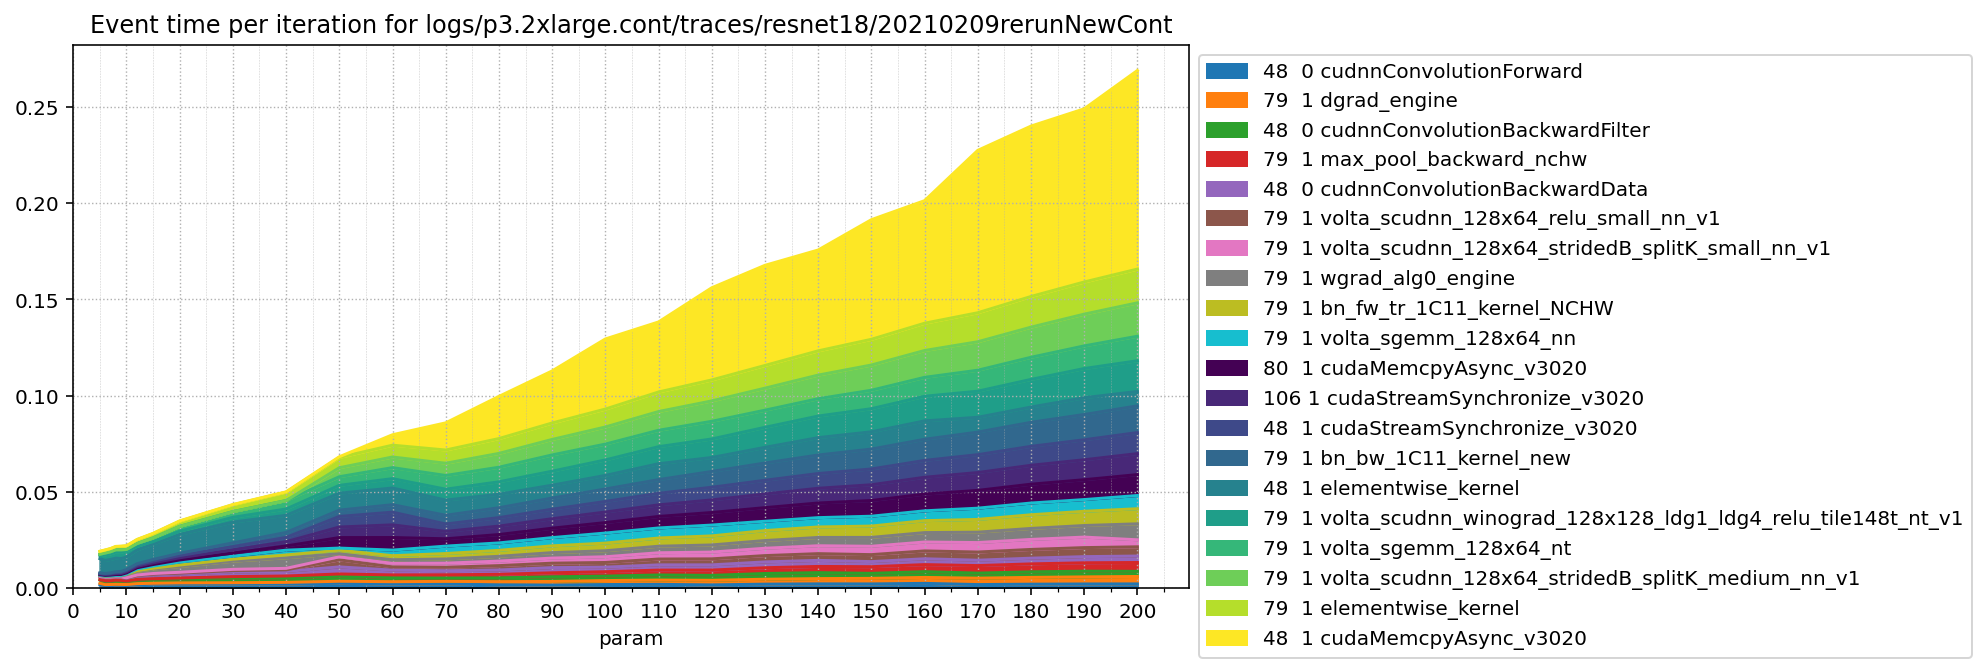

In [18]:
times  = longtimes.copy()
times.loc[:,'hascorrID'] = times.apply(lambda r: 1 if r.loc['corrID']>0 else 0, axis=1)
times.loc[:,'name'] = times.apply(lambda r: '{:<3d} {} {}'.format(r.loc['Type'],r.loc['hascorrID'],r.loc['name']), axis=1)
display(times.head())
ignorecolumns = ['start','end','corrID','hascorrID','Type']
times = times.drop(ignorecolumns,axis=1)
times = times.groupby(['param','name','iteration']).agg('sum').reset_index(drop=False)
times = times.groupby(['param','name']).agg('mean').reset_index(drop=False)
times.drop(['iteration'],axis=1,inplace=True)


times = times.pivot(index=['name'],values='duration',columns=['param']).fillna(0)
times.loc[:,'total'] = times.sum(axis=1)

times = times.sort_values(['total'],ascending=False)
display(times)
times.drop(['total'],axis=1,inplace=True)



df_ = times.head(20)
fig,ax = plt.subplots(figsize=(10,5),dpi=144)
col1 = getColorList('viridis',n=10)
col2 = getColorList('tab10',n=10)
# col3 = getColorList('tab20c',n=20)
colors = col2 + col1 
N = len(colors)
print(N)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=N)
df_.sort_values([100]).T.plot.area(cmap=cmap,ax=ax)
ax.set_xlim(0,None)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(ls=':', lw=0.7)
ax.grid(ls=':', lw=0.3, which='minor')
ax.set_title("Event time per iteration for {}".format(logdir))
leg = ax.legend(ncol=1, loc='upper left', bbox_to_anchor=(1,1))

In [19]:
# Sort events by their type
# GPU-side type 106 (Memcpy)
# GPU-side type other,
# CPU-side type 80 (cudaMemcpyAsync)
# CPU-side with corrID != 0
# CPU-side other

def sortEvents(times):
    times.loc[:,'kind'] = 'other'

    mask1 = (times['GPU side']==True)
    mask2 = (times['Type']==106)
    mask3 = (times['Type']==80)
    times.loc[mask1 & mask2,'kind'] = 'GPU memcopy sync'
    times.loc[mask1 & mask3, 'kind'] = 'GPU memcopy async'
    times.loc[mask1 & ~(mask2 | mask3), 'kind'] = 'GPU'
    
    
    mask4 = (times['corrID']!=0)
    times.loc[~mask1 & mask4, 'kind'] = 'CPU'
    return times


#     mask1 = (times['GPU side']==False)
#     mask2 = (times['name'].isin(['cudaStreamSynchronize_v3020','sem_timedwait','cudaHostAlloc_v3020']))    
#     mask1 = (times['corrID']==0)
#     times = times[~(mask1)]



times  = longtimes.copy()
times = sortEvents(times)
ignorecolumns = ['start','end','corrID']
display(times.head())
times = times.drop(ignorecolumns,axis=1)
times = times.groupby(['param','kind','iteration']).agg('sum').reset_index(drop=False)
times = times.groupby(['param','kind']).agg('mean').reset_index(drop=False)
times.drop(['iteration'],axis=1,inplace=True)


times = times.pivot(index=['kind'],values='duration',columns=['param']).fillna(0)
display(times)


# df_ = df_.sort_values(['total'],ascending=False).head(16)
# df_.drop(['total'],axis=1,inplace=True)

,name,start,end,duration,corrID,GPU side,Type,param,iteration,kind
1279,cudaMemcpyAsync_v3020,9.865490,9.865510,0.000020,7028,False,48,10,2,CPU
1280,cudaStreamSynchronize_v3020,9.865511,9.866069,0.000558,7029,False,48,10,2,CPU
1281,cudaStreamSynchronize_v3020,9.865512,9.866068,0.000556,7029,True,106,10,2,GPU memcopy sync
1282,cudaMemcpyAsync_v3020,9.865514,9.866059,0.000545,7028,True,80,10,2,GPU memcopy async
1283,cudaMemcpyAsync_v3020,9.866114,9.866129,0.000015,7037,False,48,10,2,CPU


param,5,6,7,8,9,10,12,15,20,30,...,110,120,130,140,150,160,170,180,190,200
kind,,,,,,,,,,,,,,,,,,,,,
CPU,0.013646,0.012658,0.012844,0.013111,0.012503,0.012025,0.013649,0.015188,0.019110,0.021350,...,0.057689,0.068246,0.074986,0.077213,0.086626,0.090147,0.108278,0.113729,0.116909,0.129233
GPU,0.007682,0.009284,0.009889,0.010595,0.011361,0.011914,0.013658,0.015592,0.020326,0.026401,...,0.088243,0.095113,0.105054,0.110494,0.118108,0.123797,0.133611,0.141016,0.147262,0.154980
GPU memcopy async,0.000291,0.000344,0.000399,0.000452,0.000508,0.000566,0.000675,0.000840,0.001114,0.001655,...,0.005994,0.006539,0.007083,0.007625,0.008171,0.008709,0.009259,0.009799,0.010335,0.010886
GPU memcopy sync,0.000311,0.000353,0.000407,0.000466,0.000518,0.000570,0.000681,0.000861,0.001127,0.001677,...,0.006114,0.006654,0.007216,0.007772,0.008282,0.008856,0.009378,0.009924,0.010460,0.011197
other,0.006904,0.006552,0.006507,0.006914,0.006687,0.005999,0.007614,0.008494,0.008966,0.009888,...,0.010037,0.009552,0.011010,0.011535,0.010357,0.011678,0.010052,0.010754,0.011329,0.010921


In [20]:
# times.loc[False,:].sort_values([200])
# times.loc[:,'total'] = times.sum(axis=1)

16


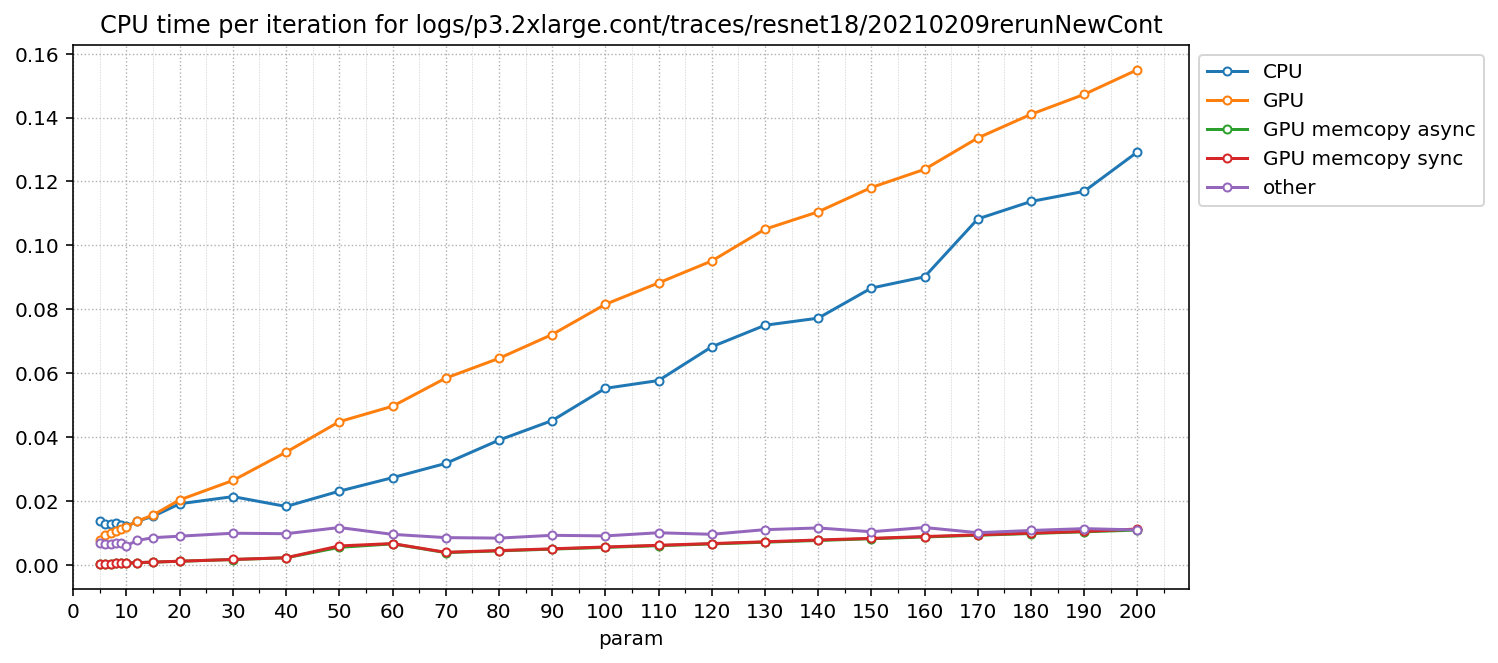

In [21]:
df_ = times.copy()
# df_ = df_.sort_values(['total'],ascending=False).head(16)
# df_.drop(['total'],axis=1,inplace=True)


fig,ax = plt.subplots(figsize=(10,5),dpi=144)
col1 = getColorList('viridis',n=6)
col2 = getColorList('tab10',n=10)
# col3 = getColorList('tab20c',n=20)
colors = col2 + col1 
N = len(colors)
print(N)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=N)
# df_.sort_values([200]).T.plot.area(cmap=cmap,ax=ax)
df_.T.plot(marker='o', ms=4, mfc='white', ax=ax)
ax.set_xlim(0,None)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(ls=':', lw=0.7)
ax.grid(ls=':', lw=0.3, which='minor')
ax.set_title("CPU time per iteration for {}".format(logdir))
leg = ax.legend(ncol=1, loc='upper left', bbox_to_anchor=(1,1))

In [22]:
df_CPUGPU = times.T
df_CPUGPU.loc[:,"GPU"] = df_CPUGPU[['GPU','GPU memcopy sync']].sum(axis=1)
df_CPUGPU.drop(['GPU memcopy sync','GPU memcopy async','other'],axis=1,inplace=True)
df_CPUGPU

kind,CPU,GPU
param,,
5,0.013646,0.007993
6,0.012658,0.009637
7,0.012844,0.010296
8,0.013111,0.011061
9,0.012503,0.011879
10,0.012025,0.012484
12,0.013649,0.014338
15,0.015188,0.016453
20,0.019110,0.021453


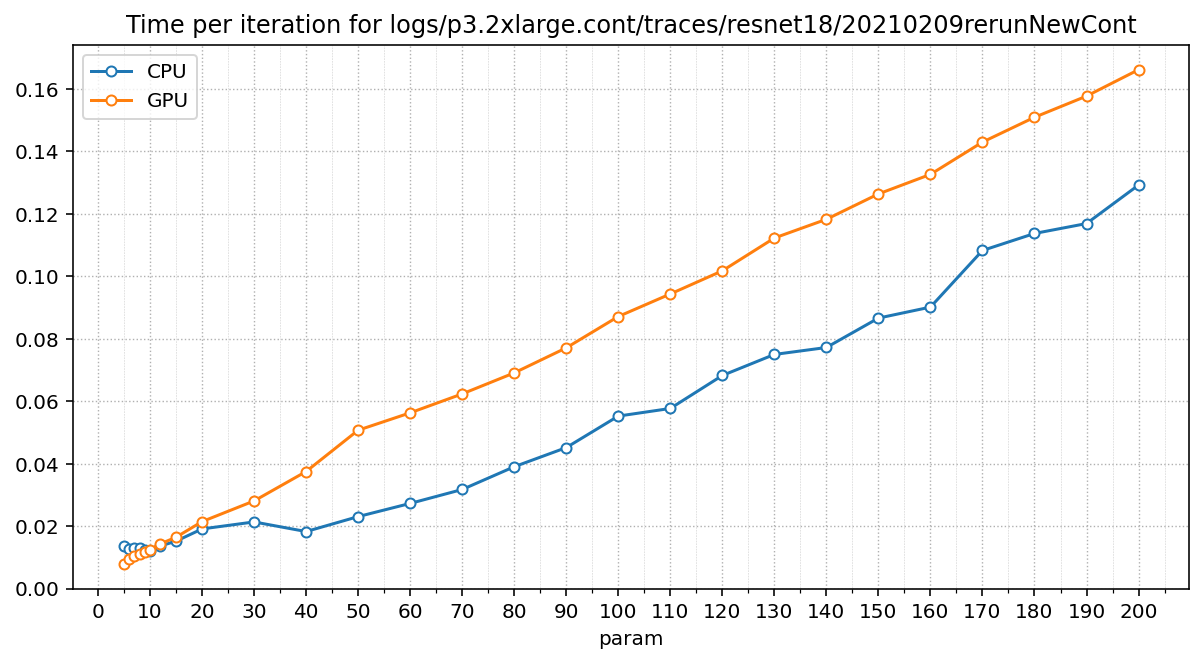

In [23]:
fig,ax = plt.subplots(figsize=(10,5),dpi=144)
df_CPUGPU.plot(ms=5,mfc='white',marker='o',ax=ax)
ax.set_ylim([0,None])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(ls=':', lw=0.7)
ax.grid(ls=':', lw=0.3, which='minor')
ax.set_title("Time per iteration for {}".format(logdir))
ax.legend()
plt.show()   

## Compare with time logs

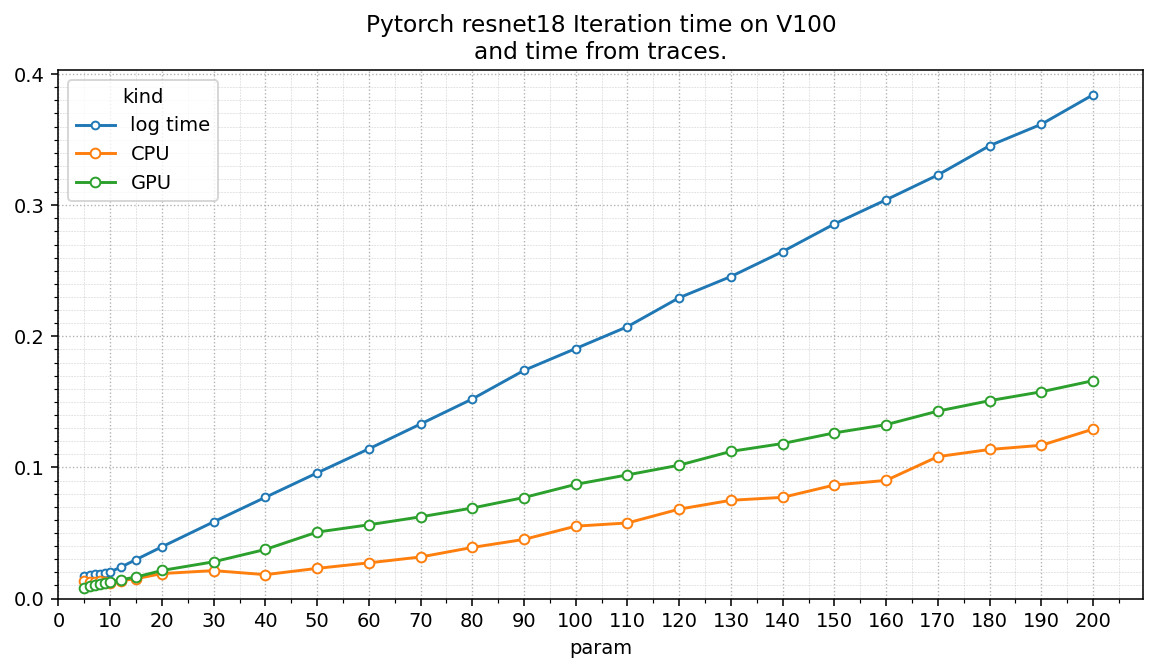

In [25]:
clean_logs = pd.read_csv("../mlbench/pytorch/logs/p3.2xlarge.cont/batchseries/imagenet/pytorch1.4.0_resnet18_20201201/clean_logs.csv")

clean_logs['iterations'] = 50000/clean_logs['batch']
clean_logs['itertime'] = clean_logs['time']/clean_logs['iterations']
# Plottable value
clean_logs['value'] = clean_logs['itertime'] 
clean_logs = clean_logs.groupby(['batch']).agg('mean')
clean_logs = clean_logs[['value']]
clean_logs.index.name = None

fig,ax = plt.subplots(figsize=(10,5),dpi=140)
clean_logs.rename(columns={"value":"log time"}).loc[clean_logs.index<=200,:].plot(marker='o',ms=4,mfc='white',ax=ax)
df_CPUGPU.plot(ms=5,mfc='white',marker='o',ax=ax)
ax.set_ylim([0,None])
ax.set_xlim([0,None])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.grid(ls=':', lw=0.3, which='minor')
ax.grid(ls=':', lw=0.7)

ax.set_title("Pytorch resnet18 Iteration time on V100\nand time from traces.")

plt.show()

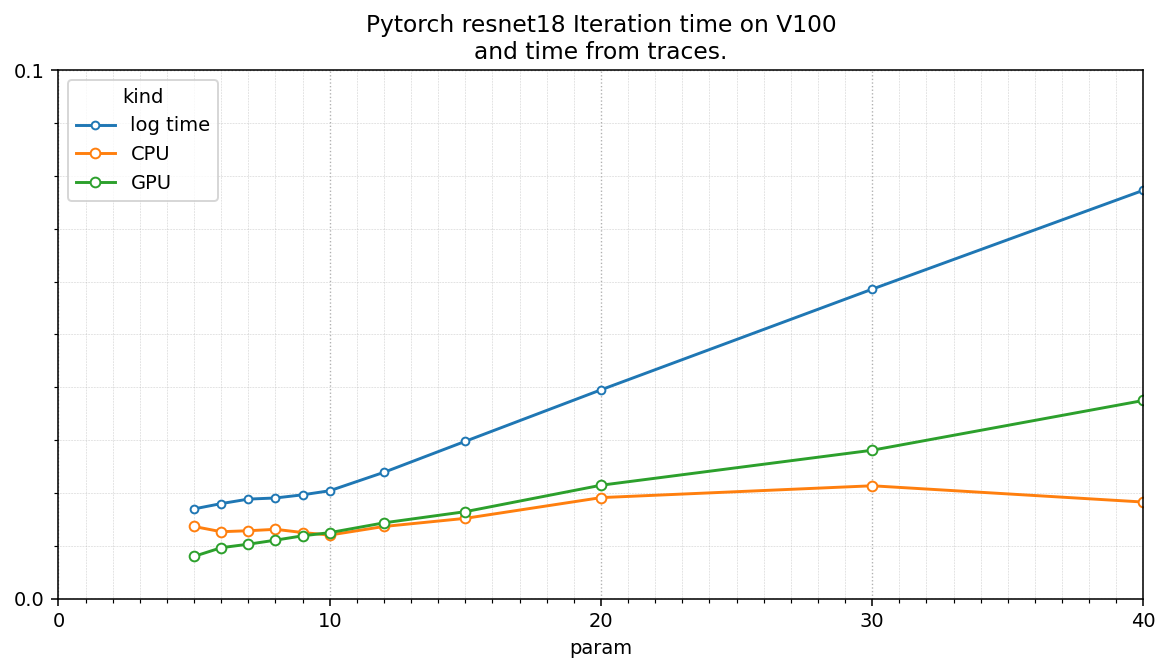

In [27]:
clean_logs = pd.read_csv("../mlbench/pytorch/logs/p3.2xlarge.cont/batchseries/imagenet/pytorch1.4.0_resnet18_20201201/clean_logs.csv")

clean_logs['iterations'] = 50000/clean_logs['batch']
clean_logs['itertime'] = clean_logs['time']/clean_logs['iterations']
# Plottable value
clean_logs['value'] = clean_logs['itertime'] 
clean_logs = clean_logs.groupby(['batch']).agg('mean')
clean_logs = clean_logs[['value']]
clean_logs.index.name = None

fig,ax = plt.subplots(figsize=(10,5),dpi=140)
clean_logs.rename(columns={"value":"log time"}).loc[clean_logs.index<=200,:].plot(marker='o',ms=4,mfc='white',ax=ax)
df_CPUGPU.plot(ms=5,mfc='white',marker='o',ax=ax)
ax.set_ylim([0,0.1])
ax.set_xlim([0,40])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.grid(ls=':', lw=0.3, which='minor')
ax.grid(ls=':', lw=0.7)

ax.set_title("Pytorch resnet18 Iteration time on V100\nand time from traces.")

plt.show()

## Approximations

### Approximate CPU time with LR

In [27]:
# Approximate column from DF with LR,
# Return model predictions.
def approximateWithLR(df,column):
    X = df.index.values
    Y = df[column].values
    model = linear_model.LinearRegression(fit_intercept=True,
                                              normalize=True)
    try:
        model = model.fit(X.reshape(-1,1),Y)
    except Exception as e:
        print(e)
        display(df)
        return None
    predictions = model.predict(X.reshape(-1,1))
    return predictions,model
    
    

In [29]:
df_

kind,CPU,GPU
param,,
5,0.025444,0.007999
6,0.026223,0.009651
7,0.026819,0.010320
8,0.027875,0.011059
9,0.029923,0.011897
10,0.031496,0.012484
12,0.033514,0.014319
15,0.034886,0.016424
20,0.038498,0.021376


AttributeError: 'Series' object has no attribute 'query'

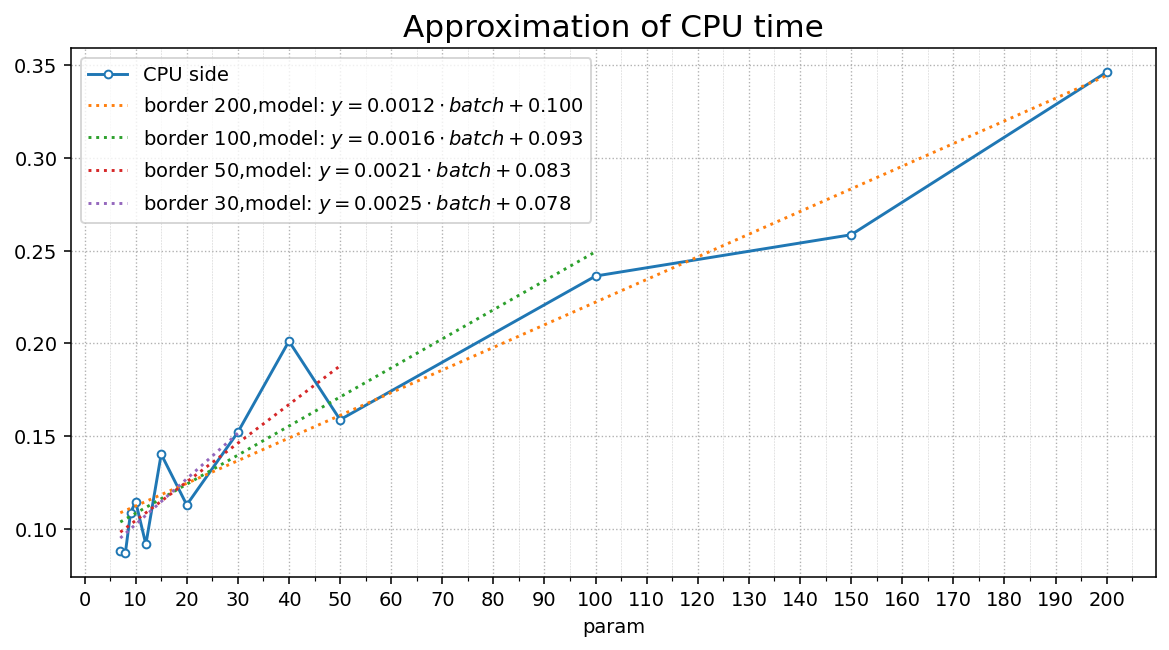

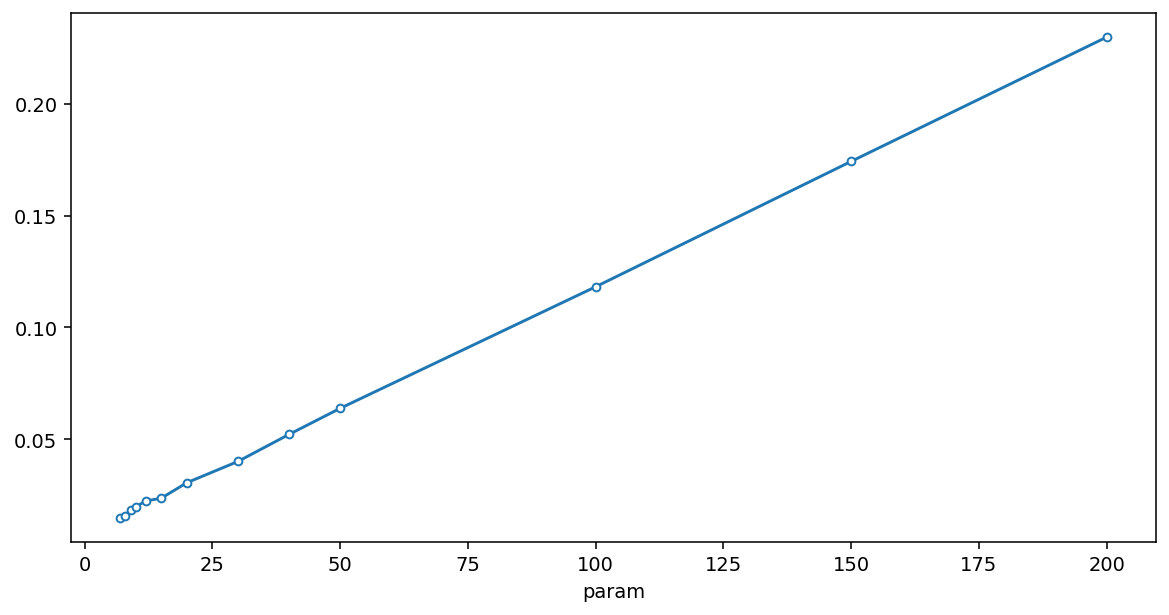

In [96]:
fig,ax = plt.subplots(figsize=(10,5),dpi=140)
# df_ = timesT.loc[:, ["CPU side"]].copy()
df_.plot(marker='o',ms=4,mfc='white',ax=ax)
for border in [200, 100, 50, 30]:
    df_ = timesT.loc[:, ["CPU side"]].query("index<=@border")
    predictions, model = approximateWithLR(df_, "CPU side")
    X = df_.index.values
    ax.plot(X,
            predictions,ls=":",
            label="border {},model: $y={:.4f} \cdot batch {:+.3f}$".format(
                border, model.coef_[0], model.intercept_))
ax.set_title("Approximation of CPU time", fontsize=16)
ax.legend()
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(ls=':', lw=0.7)
ax.grid(ls=':', lw=0.3, which='minor')

fig,ax = plt.subplots(figsize=(10,5),dpi=140)
df_ = timesT.loc[:, "GPU side"].copy()
df_.plot(marker='o',ms=4,mfc='white',ax=ax)
for border in [200, 100, 50, 30]:
    df_ = timesT.loc[:, "GPU side"].query("index>=@border")
    predictions, model = approximateWithLR(df_, "GPUtime")
    X = df_.index.values
    ax.plot(X,
            predictions,ls=":",
            label="border {},model: $y={:.5f} \cdot batch {:+.5f}$".format(
                border, model.coef_[0], model.intercept_))
ax.set_title("Approximation of GPU time", fontsize=16)
ax.legend()
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(ls=':', lw=0.7)
ax.grid(ls=':', lw=0.3, which='minor')

plt.show()